In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

import numpy as np
import os
from PIL import Image
import glob
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import cv2


In [2]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

def load_emotions_data(path):
    x = []
    y = []
    for i, emotion in enumerate(emotions):
        print(f"\r  {path}/{emotion}... ({i+1}/{len(emotions)})          ", end='')
        for filename in glob.glob(f"{path}/{emotion}/*.jpg"):
            img = Image.open(filename)
            img = np.array(img.getdata()).reshape(48, 48) / 255
            x.append(img)
            y_onehot = np.zeros(len(emotions))
            y_onehot[i] = 1
            y.append(y_onehot)
    print(f"\r  loaded {path}.                      ")
    return np.array(x), np.array(y)

print("Loading image data...")
x_train, y_train = load_emotions_data("data/train")
x_test, y_test = load_emotions_data("data/test")


Loading image data...
  loaded data/train.                      
  loaded data/test.                      


In [3]:
batch_size = 128
input_shape = (48, 48, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))
model.add(Dense(len(emotions), activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=1)

225/225 [==============================] - 30s 132ms/step - loss: 0.8215 - accuracy: 0.7016


57/57 [==============================] - 2s 32ms/step - loss: 1.4034 - accuracy: 0.4791


[1.4034197330474854, 0.47910282015800476]

57/57 [==============================] - 2s 36ms/step - loss: 1.4002 - accuracy: 0.5224


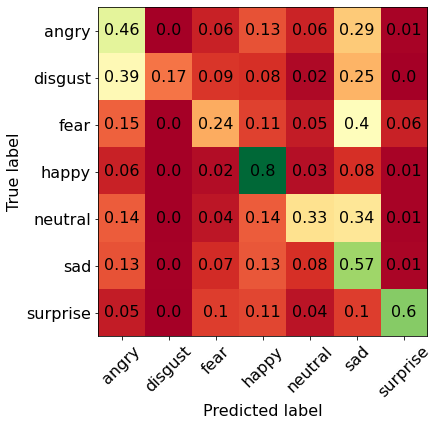

In [19]:

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlGn)
    # fig.colorbar(matrix) 
    for i in range(0,len(emotions)):
        for j in range(0,len(emotions)):  
            ax.text(j,i,np.round(cm[i,j],2),va='center', ha='center')
    ticks = np.arange(len(emotions))
    ax.set_xticks(ticks)
    ax.set_xticklabels(emotions, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(emotions)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

_ = model.evaluate(x_test, y_test, batch_size=batch_size)

y_prob = model.predict(x_test, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y_test]

plot_confusion_matrix(y_true, y_pred)
plt.show()

In [51]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(frame, 1.1, 8)

    if(len(faces) > 0):
        (x, y, w, h) = faces[0]
    else:
        x, y, w, h = 0, 0, 50, 1

    if(w > h):
        w = h
    else:
        h = w

    cropped_image = frame[y:y+h, x:x+w]

    img = Image.fromarray(cropped_image , 'L')
    img = img.resize((48, 48))
    img = np.array(img.getdata())
    img = img.reshape(1, 48, 48, 1)
    img = img/255

    y_probs = model(img).numpy().flatten()
    y_preds = np.flip(np.argsort(y_probs)).flatten()
    y_preds = [(emotions[y_preds[i]], np.round(y_probs.item(y_preds[i]), 2)) for i in range(len(emotions))]

    print(f"\r{y_preds}".ljust(150), end="")

    cv2.imshow("preview", cropped_image)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break


vc.release()
cv2.destroyWindow("preview")
cv2.waitKey(1)


[('sad', 0.86), ('neutral', 0.08), ('fear', 0.06), ('angry', 0.0), ('surprise', 0.0), ('happy', 0.0), ('disgust', 0.0)]                              

-1